In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import matplotlib.pyplot as plt
import pandas as pd
from art.attacks.evasion import ZooAttack
from art.estimators.classification import XGBoostClassifier
import os

In [2]:
dataset = np.load('data/dataset.npy')
dirx='data/x.npy'
diry='data/y.npy'
x = np.load(dirx)
y = np.load(diry)

In [3]:
_x = x
X_train, X_test, y_train, y_test = train_test_split(_x, y, test_size=.2)
bst = XGBClassifier(n_estimators=2, max_depth=3, learning_rate=1, objective='binary:logistic')
# bst.fit(X_train, y_train)
bst.load_model('2class.json')
preds = bst.predict(X_test)
print('all together acc:',(preds == y_test).sum()/len(preds))

all together acc: 0.8777777777777778


In [4]:
print(type(preds), type(y_test))
print(preds, y_test)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[1 0 0 ... 1 1 1] [1 0 0 ... 1 1 1]


In [5]:
classifier = XGBoostClassifier(model=bst, nb_features=13, nb_classes=2)

In [6]:
preds_art = np.array(classifier.predict(X_test))
# print('all together acc:',(np.round(preds).astype(int) == y_test).sum()/len(preds))

In [7]:
print(np.round(preds_art).astype(int))
np.argmax(preds_art, axis=1)

[[0 1]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


array([1, 0, 0, ..., 1, 1, 1])

In [8]:
(preds == np.argmax(preds_art, axis=1)).sum()/len(preds)

1.0

In [12]:
attack = ZooAttack(
    classifier=classifier,
    confidence=0.0,
    targeted=False,
    learning_rate=1e-1,
    max_iter=50,
    binary_search_steps=10,
    initial_const=1e-3,
    abort_early=True,
    use_resize=False,
    use_importance=False,
    nb_parallel=5,
    batch_size=1,
    variable_h=0.01,
)
x_test_adv = attack.generate(x=X_test, y=y_test)

# Step 7: Evaluate the ART classifier on adversarial test examples



ZOO:   0%|          | 0/3600 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
preds_adv = bst.predict(x_test_adv)
print('all together acc:',(preds_adv == y_test).sum()/len(preds))

[1 0 1 ... 0 1 1]
all together acc: 0.2313888888888889


In [14]:
np.save('data/preds_adv',preds_adv)
np.save('data/x_test_adv',x_test_adv)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


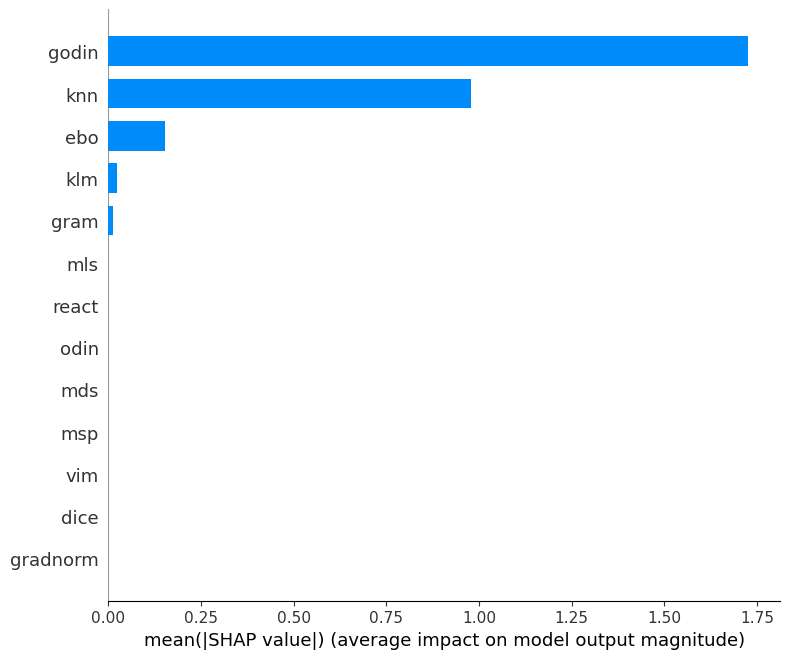

<Figure size 640x480 with 0 Axes>

In [19]:
explainer = shap.Explainer(bst)
shap_values = explainer.shap_values(x_test_adv)
shap.summary_plot(shap_values, x_test_adv, plot_type="bar", feature_names=dataset[0]['f_method'])
plt.savefig('/home/nima/OpenOOD/scripts/classifier_2/images/shap_bar_adv.png')
plt.show()


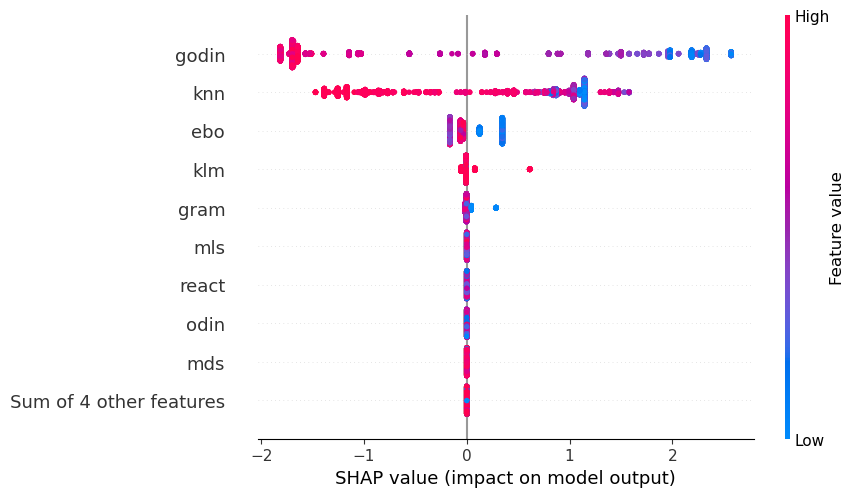

<Figure size 640x480 with 0 Axes>

In [20]:
shap_values = explainer(x_test_adv)
shap_values.feature_names = dataset[0]['f_method']
shap.plots.beeswarm(shap_values)
plt.savefig('/home/nima/OpenOOD/scripts/classifier_2/images/shap.png')
plt.clf()